In [1]:
import torch
from torch import nn

torch.__version__

'2.4.1+cu121'

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Mon Sep 30 11:40:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Get Data

Dataset is a subset of Food101 and has 3 classes and 3 images and has ~10% of data from Food101.

In [4]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download dataset
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip dataset
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


## Become one with the data(data prep and exploration)

In [5]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.


In [6]:
# Setup train and testing paths

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Write code to visualize images

- Get image paths
- Pick random image path using Python's random.choice()
- Get the image class name using `pathlib.Path.parent.stem`
- Open the image with PIL
- Show the image and print metadata

In [7]:
image_path

PosixPath('data/pizza_steak_sushi')

Random image path: data/pizza_steak_sushi/train/pizza/3269634.jpg
Image class: pizza
Image height: 512
Image width: 512


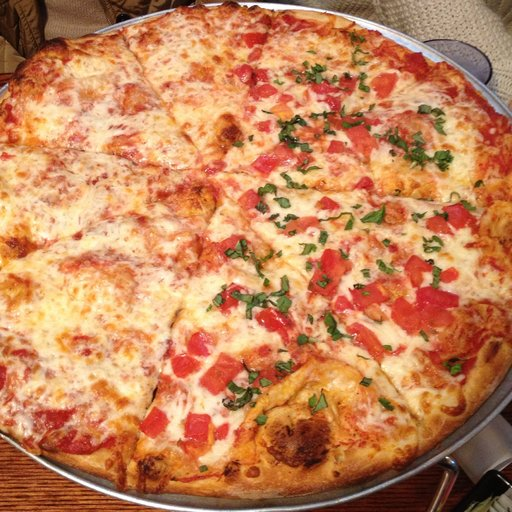

In [12]:
import random
from PIL import Image

random.seed(8)

# Get all image paths

image_path_list = list(image_path.glob("*/*/*.jpg"))

# Pick a random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

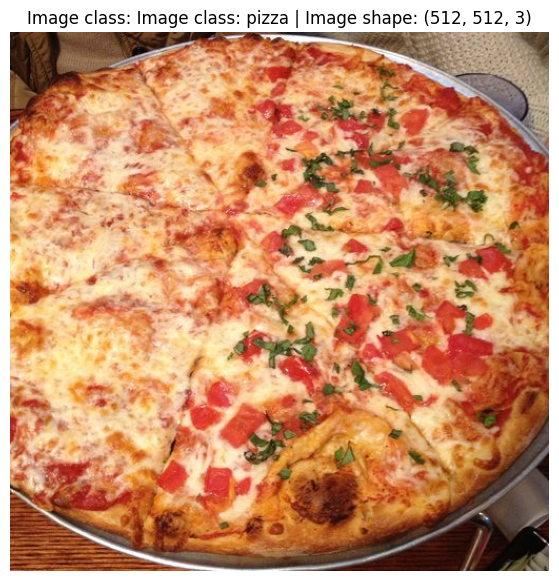

In [13]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

# Plot the image with matplolib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: Image class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False)

## Transforming data

Before we can use our image data with PyTorch:
 - Turn data into tensors(numerical repr of our images)
 - Turn into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we call this `Dataset` and `DataLoader`

In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Transform data with torchvision.transforms

In [16]:
data_transform = transforms.Compose([
    # Resize our images
    transforms.Resize(size=(64,64)),
    # Flip de images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch tensor
    transforms.ToTensor()
])

In [19]:
data_transform(img)

torch.float32

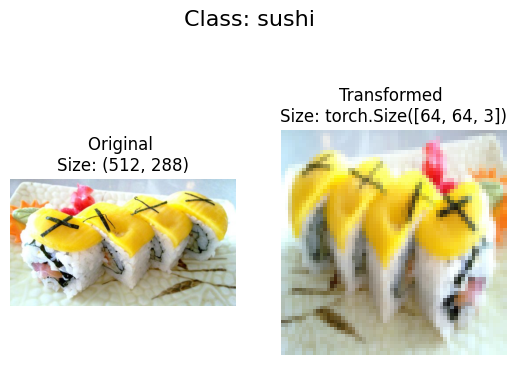

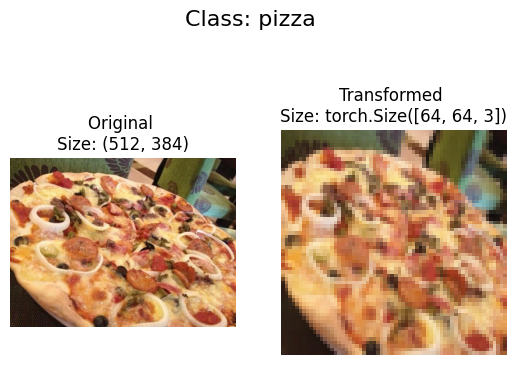

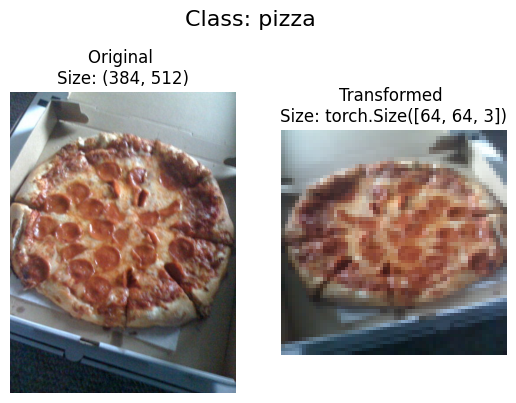

In [20]:
def plot_transofrmed_images(image_paths: list, transform, n = 3, seed = 42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k = n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
          fig, ax = plt.subplots(1,2)
          ax[0].imshow(f)
          ax[0].set_title(f"Original \nSize: {f.size}")
          ax[0].axis("off")

          # Transform and plot target image
          transformed_image = transform(f).permute(1,2,0)
          ax[1].imshow(transformed_image)
          ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
          ax[1].axis("off")

          fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

plot_transofrmed_images(image_path_list, data_transform)

## Loading image using ImageFolder
We can load image classification data using `torchvision.datasets.ImageFolder`

In [23]:
# Loading image data using ImageFolder
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform,
                                 target_transform = None)

In [24]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [26]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [27]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [28]:
# Check the length of our dataset
len(train_data), len(test_data)

(225, 75)

In [33]:
# Index on the train_data dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: {img}")
print(f"Image shape: {img.shape}")
print(f"Image type: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor: tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Image shape: torch.Size([3, 64, 64]) -> torch.Size([64, 64, 3])


(-0.5, 63.5, 63.5, -0.5)

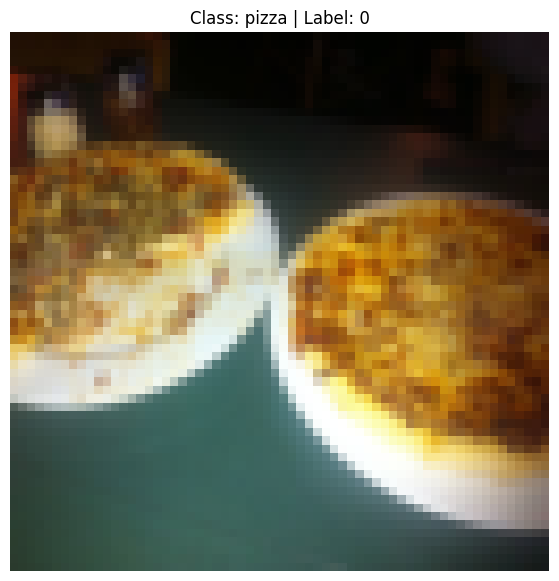

In [35]:
# rearrange order of dims
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Image shape: {img.shape} -> {img_permute.shape}")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.title(f"Class: {class_names[label]} | Label: {label}")
plt.axis("off")

### Turn loaded images into `DataLoader`'s

A dataloader is goint to help us to turn our Datasets into iterables and we can customize the batch_size so our model can see batch_size images at a time.

In [43]:
# Turn train and test datasets into DataLoaders

from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = 1,
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c1b9f54f640>,
 <torch.utils.data.dataloader.DataLoader at 0x7c1b9f54f190>)

In [44]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [45]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


## Loading image data with a custom Dataset

- Be able to load images from file
- Be able to get class names from Dataset
- Be able to get classes as dictionary

Pros:
* create a Dataset out of almost anything
* not limited to pytorch pre-built dataset functions

Cons:
* Even though you could create a dataset out of almost anything, it doesnt mean it will work
* Often results to us writing more code which could be prone to errors or performance issues

## Other forms of transforms(data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that is more generalizable to unseen data.

In [47]:
# Trivial Augment

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [48]:
# Get all image paths

image_path_list = list(image_path.glob("*/*/*.jpg"))

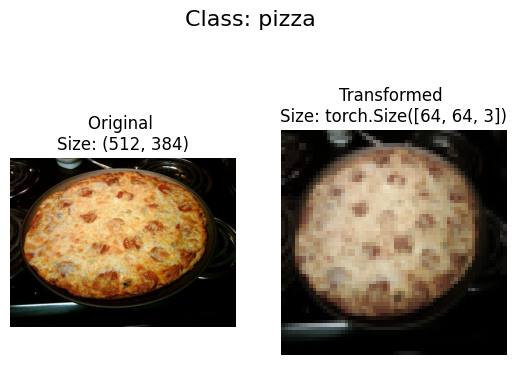

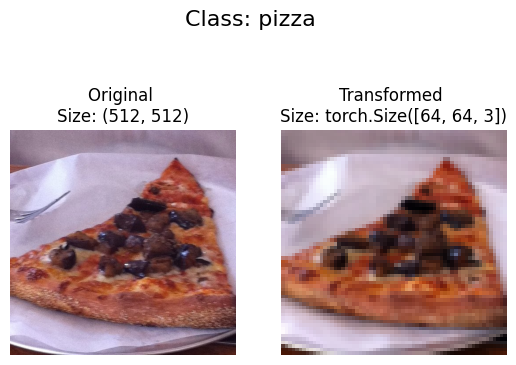

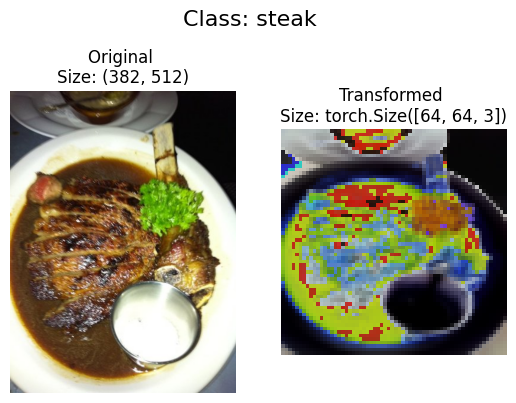

In [54]:
# Plot random images
plot_transofrmed_images(image_path_list, train_transform, 3, None)

In [60]:
# Model 0 Tiny VGG without data augmentation

# Creating transforms and loading data for Model 0

simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_data_simple = datasets.ImageFolder(root = train_dir,
                                  transform = simple_transform)

test_data_simple = datasets.ImageFolder(root = test_dir,
                                 transform = simple_transform)

train_dataloader = DataLoader(dataset = train_data_simple,
                              batch_size = BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset = test_data_simple,
                              batch_size = BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)

In [71]:
# Create TinyVGG model class

class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,
                         stride = 2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,
                         stride = 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units*13*13,
                      out_features = output_shape)
        )


    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [72]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(train_data_simple.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [73]:
# Try a forward pass on a single image(to test the model)

image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [74]:
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

In [77]:
try:
  import torchinfo
except:
  !pip install torchinfo

In [78]:
from torchinfo import summary

# use torchinfo to get an idea of the shapes going through our model

summary(model_0,
        input_size = (32, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

## Create train and test loop functions

* train_step() takes in a model and dataloader and trains the model on the dataloader
* test_step() takes in a model and a dataloader and evaluates the model on the dataloader

In [80]:
# Create train_step

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


In [82]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device = device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim = 1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)
        return test_loss, test_acc

In [124]:
# Creating a train function to combine train_step and test_step

from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          epochs,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss):
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
               }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                            dataloader = train_dataloader,
                                            loss_fn = loss_fn,
                                            optimizer = optimizer)
        test_loss, test_acc = test_step(model = model,
                                         dataloader = test_dataloader,
                                         loss_fn = loss_fn)
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [142]:
model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(train_data_simple.classes)).to(device)

In [143]:
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()

results = train(model = model_0,
                train_dataloader = train_dataloader,
                test_dataloader = test_dataloader,
                optimizer = optimizer,
                epochs = 20,
                loss_fn = loss_fn)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1071 | train_acc: 0.3008 | test_loss: 1.1027 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0953 | train_acc: 0.3750 | test_loss: 1.0761 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.1093 | train_acc: 0.2812 | test_loss: 1.0678 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.1029 | train_acc: 0.3242 | test_loss: 1.0899 | test_acc: 0.3617
Epoch: 5 | train_loss: 1.0822 | train_acc: 0.4375 | test_loss: 1.0798 | test_acc: 0.3229
Epoch: 6 | train_loss: 1.0043 | train_acc: 0.6367 | test_loss: 0.9588 | test_acc: 0.6042
Epoch: 7 | train_loss: 0.9772 | train_acc: 0.5391 | test_loss: 1.0267 | test_acc: 0.4034
Epoch: 8 | train_loss: 0.8375 | train_acc: 0.6211 | test_loss: 1.0705 | test_acc: 0.4044
Epoch: 9 | train_loss: 0.8986 | train_acc: 0.5508 | test_loss: 0.9252 | test_acc: 0.4934
Epoch: 10 | train_loss: 0.8356 | train_acc: 0.5547 | test_loss: 0.9271 | test_acc: 0.5748
Epoch: 11 | train_loss: 0.7536 | train_acc: 0.6641 | test_loss: 1.0193 | test_acc: 0.4025
Epoch: 12 | train_l

In [144]:
results

{'train_loss': [1.107084482908249,
  1.0952506810426712,
  1.1092514842748642,
  1.1028989106416702,
  1.082167312502861,
  1.0043077394366264,
  0.9772155284881592,
  0.8375461110845208,
  0.8985838890075684,
  0.8355662971735001,
  0.753555053845048,
  0.784036673605442,
  0.7838044539093971,
  0.851590670645237,
  0.7983604893088341,
  0.779346264898777,
  0.8135852292180061,
  0.7608681917190552,
  0.9013459458947182,
  0.6590753723867238],
 'train_acc': [0.30078125,
  0.375,
  0.28125,
  0.32421875,
  0.4375,
  0.63671875,
  0.5390625,
  0.62109375,
  0.55078125,
  0.5546875,
  0.6640625,
  0.6875,
  0.65625,
  0.5234375,
  0.6796875,
  0.70703125,
  0.546875,
  0.671875,
  0.56640625,
  0.7265625],
 'test_loss': [1.102710445721944,
  1.076064904530843,
  1.0677558183670044,
  1.0899228652318318,
  1.0797876914342244,
  0.9587969183921814,
  1.0266931653022766,
  1.0705122749010723,
  0.9251512289047241,
  0.9271065990130106,
  1.0193225344022114,
  1.1051440834999084,
  1.0009517

### Plot the loss curves of Model 0

A loss curve is a way of tracking your models progess over time

In [145]:
results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [146]:
def plot_loss_curves(results):
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize = (15,7))
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label = "train_loss")
    plt.plot(epochs, test_loss, label = "test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label = "train_accuracy")
    plt.plot(epochs, test_accuracy, label = "test_accuracy")
    plt.title("Accuracy")
    plt.legend()


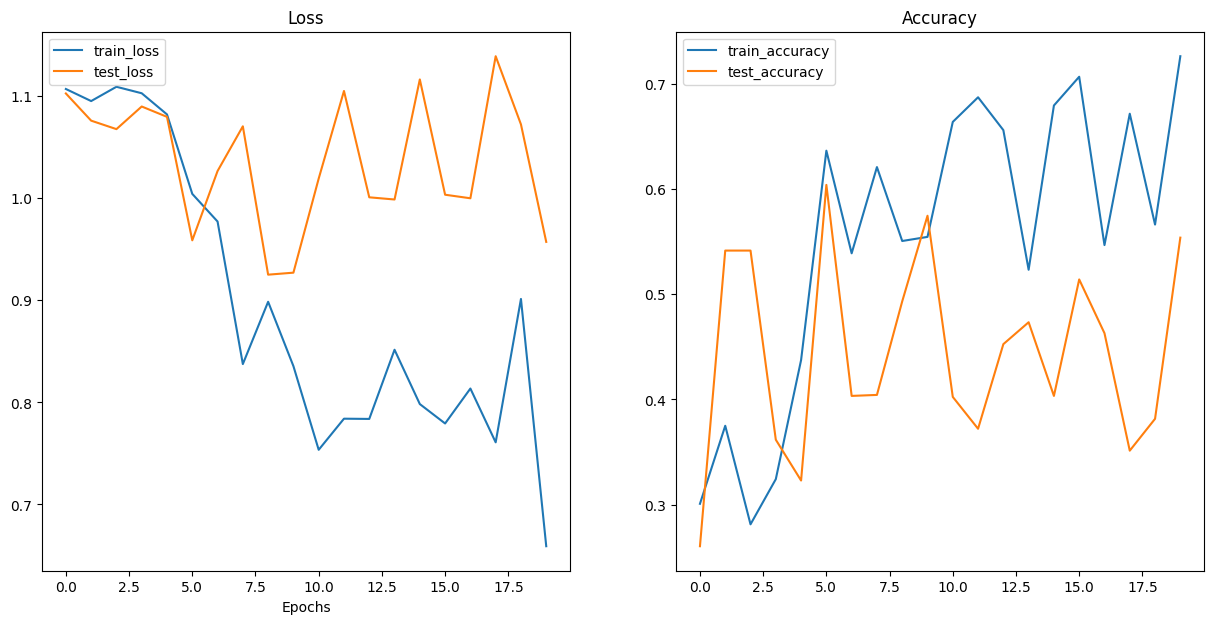

In [147]:
plot_loss_curves(results)

What should an ideal loss curve look like?

A loss curve is one of the best ways to evaluate your models performance over time.

Model 1: TinyVGG with data Augmentation

Now lets try another experiment this time using the same model as before with some data augmentaion.

In [148]:
# Create training transform with TrivialAugment

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create test transform
test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

Create train and test dataloaders

In [149]:
train_data_augmented = datasets.ImageFolder(root = train_dir,
                                  transform = train_transform_trivial,
                                  target_transform=None)
test_data_augmented = datasets.ImageFolder(root = test_dir,
                                 transform = test_transform,
                                 target_transform = None)

In [150]:
torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset = train_data_augmented,
                              batch_size = BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader_augmented = DataLoader(dataset = test_data_augmented,
                              batch_size = BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)

In [151]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(train_data_augmented.classes)).to(device)

In [152]:
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [153]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 20

optimizer = torch.optim.Adam(params = model_1.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()

results_1 = train(model = model_1,
                train_dataloader = train_dataloader_augmented,
                test_dataloader = test_dataloader_augmented,
                optimizer = optimizer,
                epochs = NUM_EPOCHS,
                loss_fn =loss_fn)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1049 | train_acc: 0.2500 | test_loss: 1.1019 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0807 | train_acc: 0.4258 | test_loss: 1.1261 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0712 | train_acc: 0.4258 | test_loss: 1.1592 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1254 | train_acc: 0.3047 | test_loss: 1.1581 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0858 | train_acc: 0.4258 | test_loss: 1.1551 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.0860 | train_acc: 0.3789 | test_loss: 1.1432 | test_acc: 0.2708
Epoch: 7 | train_loss: 1.0722 | train_acc: 0.4961 | test_loss: 1.1343 | test_acc: 0.3229
Epoch: 8 | train_loss: 1.0813 | train_acc: 0.3633 | test_loss: 1.1248 | test_acc: 0.3125
Epoch: 9 | train_loss: 1.0819 | train_acc: 0.4219 | test_loss: 1.0860 | test_acc: 0.3438
Epoch: 10 | train_loss: 1.0050 | train_acc: 0.4297 | test_loss: 0.9595 | test_acc: 0.5445
Epoch: 11 | train_loss: 0.9749 | train_acc: 0.5703 | test_loss: 0.9908 | test_acc: 0.3627
Epoch: 12 | train_l

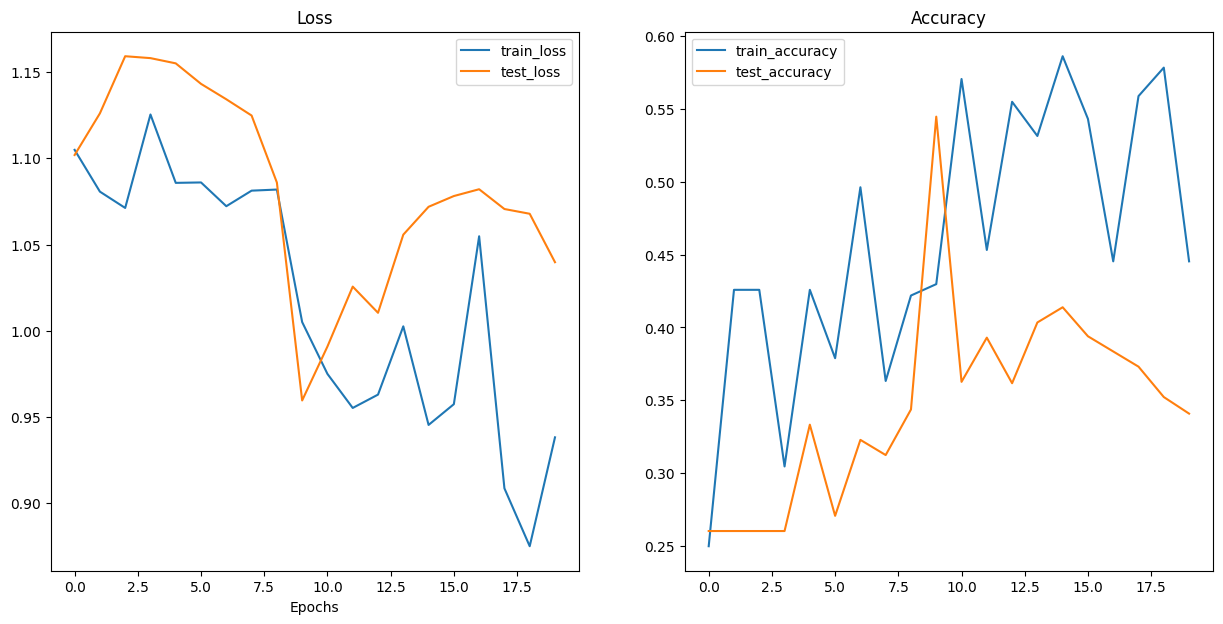

In [154]:
plot_loss_curves(results_1)

## Compare model results

After evaluating our modelling experiments it is important to compare them to each other

Methods of doing this:
- Hardcoding (what we re doing)
- Tensorboard + PyTorch
- Weights & Biases
- MLFlow

In [155]:
import pandas as pd
model_0_df = pd.DataFrame(results)
model_1_df = pd.DataFrame(results_1)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107084,0.300781,1.102710,0.260417
1,1.095251,0.375000,1.076065,0.541667
2,1.109251,0.281250,1.067756,0.541667
3,1.102899,0.324219,1.089923,0.361742
4,1.082167,0.437500,1.079788,0.322917
5,1.004308,0.636719,0.958797,0.604167
6,0.977216,0.539062,1.026693,0.403409
7,0.837546,0.621094,1.070512,0.404356
8,0.898584,0.550781,0.925151,0.493371
9,0.835566,0.554688,0.927107,0.574811


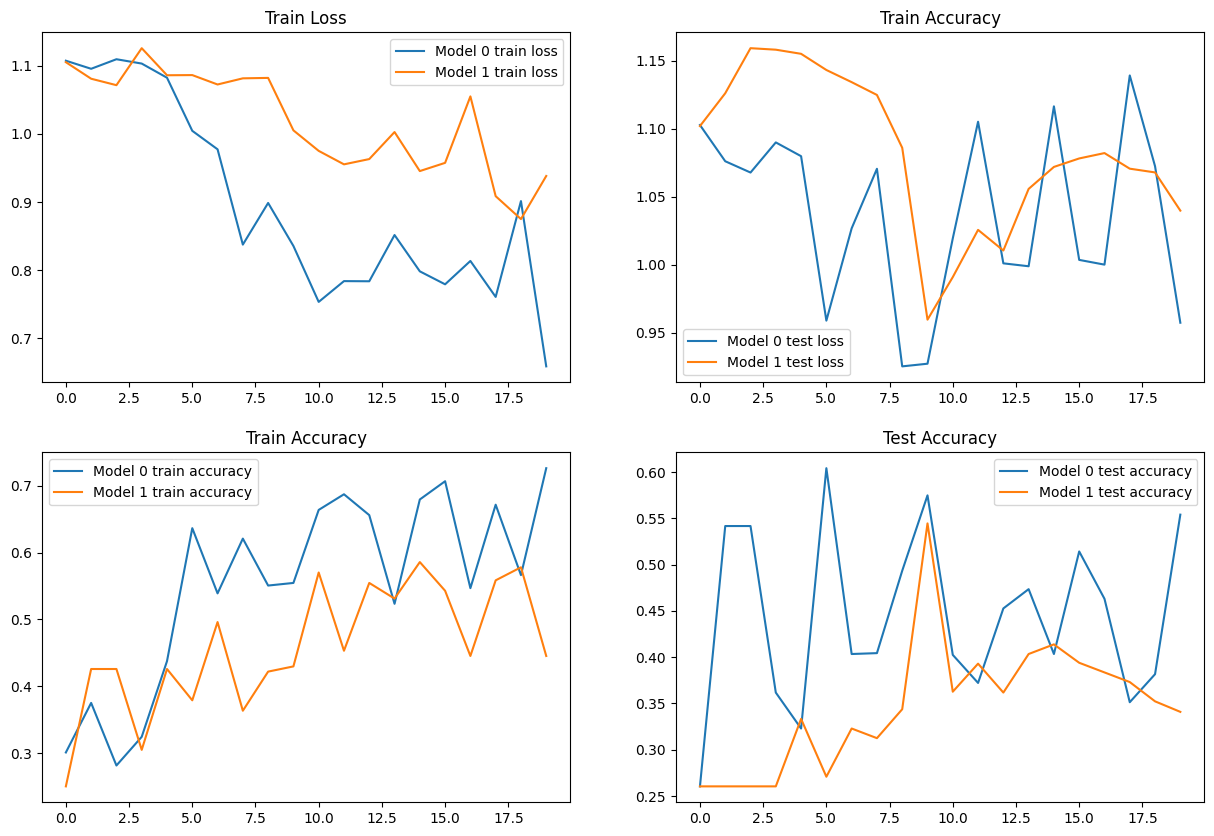

In [156]:
# Setup a plot
plt.figure(figsize = (15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label = "Model 0 train loss")
plt.plot(epochs, model_1_df["train_loss"], label = "Model 1 train loss")
plt.title("Train Loss")
plt.legend()

plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label = "Model 0 test loss")
plt.plot(epochs, model_1_df["test_loss"], label = "Model 1 test loss")
plt.title("Train Accuracy")
plt.legend()

plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label = "Model 0 train accuracy")
plt.plot(epochs, model_1_df["train_acc"], label = "Model 1 train accuracy")
plt.title("Train Accuracy")
plt.legend()

plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label = "Model 0 test accuracy")
plt.plot(epochs, model_1_df["test_acc"], label = "Model 1 test accuracy")
plt.title("Test Accuracy")
plt.legend()

